In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random

In [20]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

# colors = np.random.randint(0, 255, (len(labels_index), 3))
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_index['BackG']] = 1.

In [21]:
# build training data

# sift_dir = '/oasis/projects/nsf/csd395/yuncong/Brain/learning/sift'
sift_dir = '/oasis/projects/nsf/csd395/wel144/2016-brainstem/sift'

train_data = []
train_labels = []

n_sample = 1000

for name in labels[1:]:
    train_hists0 = bp.unpack_ndarray_file(sift_dir + '/train/MD589_%(name)s_histograms_l0.bp' % {'name': name})
    train_hists1 = bp.unpack_ndarray_file(sift_dir + '/train/MD589_%(name)s_histograms_l1.bp' % {'name': name})
    train_hists2 = bp.unpack_ndarray_file(sift_dir + '/train/MD589_%(name)s_histograms_l2.bp' % {'name': name})
    
    n_train = train_hists0.shape[0]
    print (name, n_train),

    #     train_hists = np.c_[train_hists0, train_hists1.reshape((n_train, -1)), train_hists2.reshape((n_train, -1))]

    random_indices = np.random.choice(range(n_train), min(n_train, n_sample), replace=False)
    n_train = len(random_indices)
    train_hists = np.c_[train_hists0[random_indices], 
                        train_hists1[random_indices].reshape((n_train, -1)), 
                        train_hists2[random_indices].reshape((n_train, -1))]
    
    train_data.append(train_hists)
    train_labels.append(np.ones((n_train, )) * labels_index[name])
    print n_train
    

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)
n_train = train_data.shape[0]

('5N', 1440) 1000
('7n', 3444) 1000
('7N', 2579) 1000
('12N', 1230) 1000
('Pn', 3042) 1000
('VLL', 1287) 1000
('6N', 154) 154
('Amb', 346) 346
('R', 1082) 1000
('Tz', 1387) 1000
('RtTg', 2639) 1000
('LRt', 1050) 1000
('LC', 481) 481
('AP', 483) 483
('sp5', 3240) 1000


In [22]:
train_data.shape

(12464, 4200)

In [23]:
train_data_normalized = train_data / train_data.sum(axis=1)[:,None].astype(np.float)
train_data_normalized = np.nan_to_num(train_data_normalized)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [24]:
bp.pack_ndarray_file(train_data_normalized, 'preprocessed/train_data.bp')
bp.pack_ndarray_file(train_labels, 'preprocessed/train_labels.bp')

In [25]:
# build testing data

stack = 'MD585'

first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]

sec = first_detect_sec

test_hists0 = bp.unpack_ndarray_file(sift_dir + '/%(stack)s/%(stack)s_%(sec)04d_roi1_histograms_l0.bp' % {'stack': stack, 'sec': sec})
test_hists1 = bp.unpack_ndarray_file(sift_dir + '/%(stack)s/%(stack)s_%(sec)04d_roi1_histograms_l1.bp' % {'stack': stack, 'sec': sec})
test_hists2 = bp.unpack_ndarray_file(sift_dir + '/%(stack)s/%(stack)s_%(sec)04d_roi1_histograms_l2.bp' % {'stack': stack, 'sec': sec})

n_test = test_hists0.shape[0]
test_hists = np.c_[test_hists0, test_hists1.reshape((n_test, -1)), test_hists2.reshape((n_test, -1))]

test_data = test_hists

In [26]:
test_data.shape

(20979, 4200)

In [27]:
test_data_normalized = test_data / test_data.sum(axis=1)[:,None].astype(np.float)

In [28]:
bp.pack_ndarray_file(test_data_normalized, 'preprocessed/%(stack)s_test_data.bp' % {'stack': stack})

In [29]:
# method 1
t = time.time()

def compute_intersection_kernel_oneJob(i, j1):
#     dist = .5 * np.sum(train_data_normalized + h - np.abs(train_data_normalized - h), axis=1)
    dist = np.minimum(train_data_normalized[i], train_data_normalized[j1:]).sum(axis=1)
    return dist

train_dist_triangle = np.concatenate(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(i, i) 
                                     for i in range(n_train)))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 200s / 12k training data

train_dist_mat = np.empty((n_train, n_train))
train_dist_mat[np.triu_indices(n_train)] = train_dist_triangle
r = np.tril_indices(n_train)
train_dist_mat[r] = train_dist_mat.T[r]


compute intersection kernel: 192.439459 seconds


In [30]:
# method 2
t = time.time()

def compute_intersection_kernel_oneJob(h):
#     dist = .5 * np.sum(train_data_normalized + h - np.abs(train_data_normalized - h), axis=1)
    dist = np.minimum(train_data_normalized, h).sum(axis=1)
    return dist

# train_dist_mat = np.array(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(h) 
#                                      for h in train_data_normalized[:1000]))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

compute intersection kernel: 0.000318 seconds


In [31]:
# method 3
t = time.time()

def compute_intersection_kernel_oneJob(i, ni, j, nj):
    dists = np.minimum(train_data_normalized[i:i+ni, None], train_data_normalized[j:j+nj]).sum(axis=-1)
    return dists

# train_dist_mat = np.empty((n_train, n_train))
# ni = 100
# nj = 100
# for j in range(0, n_train, nj):
#     train_dist_mat[:, j:j+nj] = np.concatenate(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(i, ni, j, nj) 
#                                                     for i in range(0, n_train, ni)))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

compute intersection kernel: 0.000340 seconds


In [32]:
train_dist_mat.shape

(12464, 12464)

In [33]:
bp.pack_ndarray_file(train_dist_mat, 'preprocessed/train_spm_dist_mat.bp')

In [16]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, acc, unweighted_acc,
                 label_distribution, center_index, neighbor_indices):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.acc = acc # Weighted accuracy
        self.unweighted_acc = unweighted_acc
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, abstain_thres, growth_radius):
        
        self.init_radius = init_radius
        self.abstain_thres = abstain_thres
        self.growth_radius = growth_radius
    
    def generate(self, train_X, train_y, train_kernel, D, n_class):
        
        n_samples = train_X.shape[0]

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]
    #     print 'exemplar: ', exemplar_index
    #     print 'exemplar label: ', y[exemplar_index]

        # Calculate dist to all other
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
#         sorted_X = train_X[sorted_indices]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]
    #     print sorted_y[:10]
    #     print sorted_scores[:10]
    #     print sorted_scores[-10:]

        # Calculate plurarity of initial sphere & abstain
        count = np.bincount(sorted_y[:self.init_radius],
                            weights=sorted_D[:self.init_radius],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:self.init_radius],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
    #     print count, np.sum(sorted_D[:self.init_radius]), len(count)
    #     print unweighted_count, len(count)
    #     print 'interest label: ', y_of_interest

        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:self.init_radius])
    #     print 'percentage: ', percentage

        # Abstain test
        if percentage<self.abstain_thres or np.sum(sorted_scores)==0.0:#HACK to avoid 0 threshold
    #         print "Abstain"
#             continue
            return None, None

        # Caculate best radius
        index_of_interest = np.array([y_==y_of_interest for y_ in sorted_y])
        weight_of_interest = np.cumsum(index_of_interest*sorted_D)
        best_radius = self.init_radius
        best_percentage = percentage
        for i in range(self.init_radius+self.growth_radius, n_samples, self.growth_radius):
            perc = weight_of_interest[i-1]*1.0 / np.sum(sorted_D[:i])
            if perc>best_percentage:
                best_radius = i
                best_percentage = perc
    #         print (i, perc)
    #     print (best_radius, best_percentage)

        # Alpha
        w_total = np.sum(sorted_D[:best_radius])
        w_acc = weight_of_interest[best_radius-1]*1.0 / w_total
        w_err = 1.0 - w_acc
    #     print 'weighted_total: ', w_total
    #     print 'weighted_acc: ', w_acc
    #     print 'weighted_err: ', w_err

        epsilon = 1.0e-10
        alpha = 0.5 * math.log((w_acc+epsilon)/(w_err+epsilon))
    #     print 'alpha: ', alpha

        # Store weakleaner in storing class
        acc = np.sum(index_of_interest[:best_radius])*1.0 / best_radius
        threshold = sorted_scores[best_radius-1]

        if threshold==0.0:
            print 'Scores w/ 0.0 thres: ', sorted_scores[:best_radius],
            print np.sum(train_kernel[exemplar_index])
            return None, None

        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
    #     print 'acc: ', acc
    #     print label_distribution
    #     plt.bar(np.arange(0,16), label_distribution, width=1)
    #     plt.show()

        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, w_acc, acc, label_distribution,
                                exemplar_index, sorted_indices)
        return h, index_of_interest



In [17]:
# Adaboost.M1

class Adaboost_M1:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.n_class = n_class
        self.weaklearner = weaklearner
        self.D = None
        self.H = []
    
    def train(self, train_X, train_y, train_kernel):
        
        if not self.weaklearner:
            raise ValueError("There is no weaklearner generator.");
        
        n_samples = train_X.shape[0]
        self.D = (1.0/n_samples) * np.ones((n_samples, ))

        for t in xrange(self.T):

            if t%100==0:
                print 't: ', t
                
            h, index_of_interest = \
                self.weaklearner.generate(train_X, train_y, train_kernel, self.D, self.n_class)
            
            if not h: #Abstained
                continue
                
            self.H.append(h)

            # Reweight
            index_of_other = ~index_of_interest
        #     print 'labels: ', train_y[:20]
            self.D[h.neighbor_indices] = self.D[h.neighbor_indices] + index_of_interest*math.exp(-1.0*h.alpha)
        #     print 'interest: ', self.D[:20]
            self.D[h.neighbor_indices] = self.D[h.neighbor_indices] + index_of_other*math.exp(h.alpha)
        #     print 'others: ', self.D[:20]

            # Normalize
            self.D = self.D*1.0 / np.sum(self.D)
        #     print 'reweighted sum: ', np.sum(self.D)
            
        print 'Num classifiers: ', len(self.H)

    def predict_with_kernel(self, train_X, train_y, train_kernel):

        n_samples = train_kernel.shape[1]
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
        print 'n: ', n_samples

        for i in xrange(1, len(self.H)+1):

            classifiers = self.H[:i]
            prob = np.zeros((n_samples, self.n_class))
            for clf in classifiers:
                score = np.copy(train_kernel[clf.center_index])
        #         print (clf.label, clf.thres, clf.alpha, np.sum(score>=clf.thres))
                score[score < clf.thres] = 0.0 #Predict as not clf.label
                score[score >= clf.thres] = clf.alpha #Predict as clf.label
        #         print (np.sum(score>0.0), np.sum(prob[:, clf.label]))
                prob[:, clf.label] += score
        #         print 'after: ', np.sum(prob[:, clf.label])*1.0/np.sum(score>0.0)

            max_prob = np.max(prob, axis=1)
            pred_y = np.argmax(prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i-1,:] = pred_y

        print ''
        print 'Classifier size: ', staged_pred_y.shape
        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        return staged_pred_y


In [18]:
t = time.time()

# Load preprocessed data
train_X = bp.unpack_ndarray_file('preprocessed/train_data.bp')
train_y = bp.unpack_ndarray_file('preprocessed/train_labels.bp')
train_kernel = bp.unpack_ndarray_file('preprocessed/train_spm_dist_mat.bp')

weak = WeakLearner_generator(init_radius=50, 
                             abstain_thres=0.5,
                             growth_radius=10)
ada = Adaboost_M1(iterations=2000, 
                  n_class=16, 
                  weaklearner=weak)

sys.stderr.write('Load & setup time: %f seconds\n' % (time.time() - t)) # ~ 350s / 12k training data

Train time: 2.094894 seconds


In [19]:
t = time.time()
ada.train(train_X, train_y, train_kernel)
sys.stderr.write('Train time: %f seconds\n' % (time.time() - t)) # ~ 15s / 12k training data

t:  0
t:  100
t:  200
t:  300
t:  400
t:  500
t:  600
t:  700
t:  800
t:  900
t:  1000
t:  1100
t:  1200
t:  1300
t:  1400
t:  1500
t:  1600
t:  1700
t:  1800
t:  1900
Num classifiers:  446


Train time: 15.286508 seconds


In [20]:
print 'Labels: ', set([h.label for h in ada.H])

Labels:  set([2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15])


In [21]:
t = time.time()
staged_pred_y = ada.predict_with_kernel(train_X, train_y, train_kernel)
sys.stderr.write('Test time: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

n:  12464

Classifier size:  (446, 12464)
Correct predictions:  3533


Test time: 13.358491 seconds


In [22]:
final_y = staged_pred_y[-1]
print 'Label 0: ', np.sum(final_y==0)
print 'Labels: ', set(final_y)

Label 0:  6658
Labels:  set([0, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15])


In [24]:
train_tp=[];
train_abstain_rate = [];
n_training = len(staged_pred_y[0])
for pred_y in staged_pred_y:
    n_abstain = np.sum(pred_y==0);
    n_tp_total = np.sum(pred_y!=0);
    n_tp_correct = np.sum(pred_y==train_y);
    
    train_tp.append(1.0 * n_tp_correct / n_tp_total);
    train_abstain_rate.append(1.0 * n_abstain / n_training);

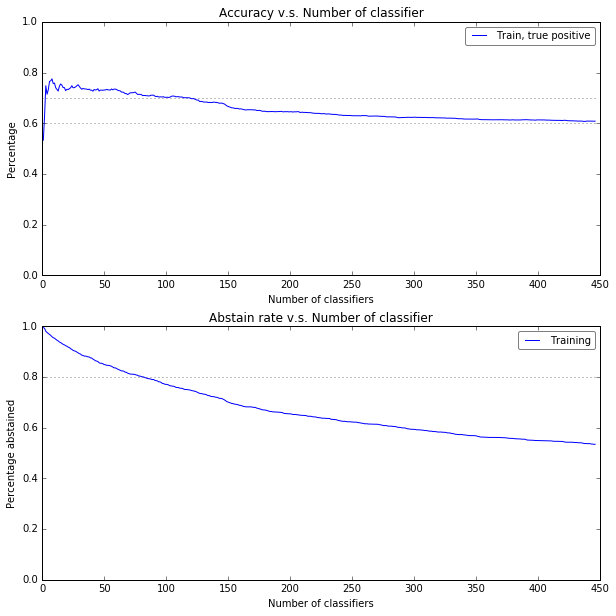

In [27]:
n_clf = len(ada.H);
plt.figure(figsize=(10,10));
plt.subplot(211);
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_tp, label='Train, true positive');
# plt.plot(range(1, n_clf + 1), test_staged_tp, label='Test, true positive');
# plt.plot(range(1, n_clf + 1), train_staged_fp, label='Train, bg false positive');
# plt.plot(range(1, n_clf + 1), test_staged_fp, label='Test, bg false positive');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
plt.hlines(0.7, 0, n_clf, linestyles=':', color='grey');
plt.hlines(0.6, 0, n_clf, linestyles=':', color='grey');

plt.subplot(212);
plt.title("Abstain rate v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage abstained");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, n_clf + 1), train_abstain_rate, label='Training');
# plt.plot(range(1, n_clf + 1), test_abstain_rate, label='Testing');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
plt.hlines(0.8, 0, n_clf, linestyles=':', color='grey');

In [ ]:
# Adaboost.M2

